# Completion, MLP.ipynb

Most of the code is the same as the HSI_loader.ipynb, except for the model is changed from decision tree regressor to the MLP.

Basically, my program follow these steps :

1. load the csv
2. train 2 models to predict the melanin and BlSDBN, X is [:, 46:67]
3. Evaluate 2 models on the given csv (train test split, cross_validation)
   1. use MSE, R2, etc for the performance metric
   2. performance result is written in the report
4. load (Data_Mike/.mat)['R1'][:,:,0:42:2]
5. reshape to (202 * 202, 21), replace inf to 0
6. use the trained model to predict mel and BlSDBN from .mat file
7. save these 2 predicted results, and reshape them back to (202,202)
8. plot these 2 predicted results
9. Go back to step 2, tune the hyper parameters of 2 models, try to get as better models as possible.
10. Code is done, the readme report includes:
   1. The performance results when training on the given .csv
   2. Compare images predicted by our best model(i.e. with hyper parameters), and the provided images in the A3_Framework folder
      1. make biology inference, and make the qualitative comparison of images
      

We just use different models for core, completion and challenge. Others are the same

In [6]:
from scipy.io import loadmat
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import csv
import time
import sys
import torch
import torchmetrics  # metrics like accuracy, recall, etc
import torch.nn as nn
# from torch import nn
from torch.nn.modules.container import Sequential
import torch.nn.functional as F


from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from copy import deepcopy
from sklearn.neural_network import MLPRegressor


DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print("we can use:", DEVICE, "to run the Model ")

we can use: cpu to run the Model 


In [7]:

#dataset_path = sys.argv[1];
#folder = sys.argv[2];
#filename = sys.argv[3];

dataset_path = "MC_Modeled_spectra.csv"; # monte carlo dataset 
folder = "Data_Mike" + "/";
filename = "R_(1measurement)_normalized_NoGap[202,202,79].mat"; # hyperspectral image(pixels, wavelengths)


HSI_mat_data_file_to_load = folder + filename; # HSI file
# copy from the given code, it will be saved by using np.save() with the format of .npy
saved_Results_file = folder + filename + dataset_path; 
provided_npy_file = "R_(1measurement)_normalized_NoGap[202,202,79].matData_small.csv.npy"
Results_from_given_npy = np.load(provided_npy_file, allow_pickle=True)
print("Results.shape", Results_from_given_npy.shape)

Hyperspectra_data = loadmat(HSI_mat_data_file_to_load)['R1'];
(x_total, y_total, wavelenght) = Hyperspectra_data.shape;
print("Hyperspectral data: x_total:", x_total, "y_total:", y_total, "wavelengh:", wavelenght);

Hyperspectra_data_resized = Hyperspectra_data[:,:, 0:42:2]; # Get from 510 to 720 nm with 10nm step size
print(f"Resized Hyperspectra data shape : {Hyperspectra_data_resized.shape}")


Results.shape (202, 202, 11)
Hyperspectral data: x_total: 202 y_total: 202 wavelengh: 79
Resized Hyperspectra data shape : (202, 202, 21)


In [11]:
def mse_loss(y_pred, y_true):
    squared_error = (y_pred - y_true) ** 2
    sum_squared_error = np.sum(squared_error)
    mse_loss = sum_squared_error / y_true.size
    sse = sum((y_true - y_pred)**2)
    tse = (len(y_true) - 1) * np.var(y_true, ddof=1)
    r2_score = 1 - (sse / tse)    
    return mse_loss, r2_score, sse, tse

In [6]:



def get_and_train_model_on_MCModelcsv(ds, y_name , model = MLPRegressor()):
    y = ds[y_name].values
    X = ds.iloc[:, 46:67].values # 46:67 are from 510 to 720 nm with 10nm step size
    std_slc = StandardScaler()
    pipline_mlp = Pipeline([('std_slc', std_slc), ('model', model)])
    # set up the Randomized search hyper parameters for MLP_randomizedCV
    parameters = dict(
        model__hidden_layer_sizes=[
            (100, 100, 100),
            (100, 100), 
            (100, 100, 100, 100), 
            (100, 100, 100, 100, 100)], 
        model__activation=['relu', 'tanh', 'logistic'],
        model__solver=['adam', 'sgd', 'lbfgs'], 
        model__alpha=[0.0001, 0.05], 
        model__learning_rate=['constant', 'adaptive'],
        model__max_iter=[200, 500, 1000]
        )
    
    MLP_randomizedCV = RandomizedSearchCV(pipline_mlp, parameters)

    MLP_randomizedCV.fit(X, y)
    print('-'*80)
    # print the best hyperparameters
    print(f"Best hyperparameters for {y_name}:")
    print(f"\t{MLP_randomizedCV.best_params_}")
    print(f"\t{MLP_randomizedCV.best_estimator_.get_params()['model']}")
    
    cv_results = cross_val_score(MLP_randomizedCV, X, y, cv=3, scoring='neg_mean_squared_error')
    print(f"Cross validation results for {y_name}, scoring = 'neg_mean_squared_error':")
    print(f"cv results: {cv_results}")
    print(f"cv results mean: {cv_results.mean()}")
    print(f"cv results std: {cv_results.std()}")
    
    return MLP_randomizedCV, X, y # return the model with best hyperparameters
    
    
ds = pd.read_csv(dataset_path) # read the csv file
trainedMelModel, _, _ = get_and_train_model_on_MCModelcsv(ds, 'Mel' )
trainedBlSDBNModel, _, _ = get_and_train_model_on_MCModelcsv(ds, 'BlSDBN')

--------------------------------------------------------------------------------
Best hyperparameters for Mel:
	{'model__solver': 'lbfgs', 'model__max_iter': 200, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (100, 100, 100, 100, 100), 'model__alpha': 0.0001, 'model__activation': 'tanh'}
	MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100, 100),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=200, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
             verbose=False, warm_start=False)


/usr/pkg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/pkg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/pkg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/pkg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/pkg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: Conve

Cross validation results for Mel, scoring = 'neg_mean_squared_error':
cv results: [-0.00120892 -0.0003216  -0.00305925]
cv results mean: -0.00152992068513566
cv results std: 0.0011404569795867014
--------------------------------------------------------------------------------
Best hyperparameters for BlSDBN:
	{'model__solver': 'lbfgs', 'model__max_iter': 500, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (100, 100, 100, 100, 100), 'model__alpha': 0.05, 'model__activation': 'tanh'}
	MLPRegressor(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100, 100),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=500, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
    

KeyboardInterrupt: 

`The above process is stopped as the kernel is dead, but luckily the mel and BlSDBN models with best hyperparameters are printed. Due to the performance metrics for the BlSDBN is not printed successfully above, I will use the train_test_split to print and evaluate it .`

In [12]:
def get_and_train_MLPGridCVModel(ds=pd.read_csv(dataset_path)) :
    """
    This method will return the trained model for Mel and BlSDBN.
    
    Due to the death of the kernel when runing the GridSearch to find the best hyperparameters, everything disappear except the above printted results. Hence, this method will fit and return the trained model for Mel and BlSDBN.

    """
    
    X, y = ds.iloc[:, 46:67].values, ds['BlSDBN'].values # 46:67 are from 510 to 720 nm with 10nm step size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    # for meline, as it is stoped due to the death of the kernel, so fit and return it again
    mlp_mel_gridCV = MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100, 100),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=200, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
             verbose=False, warm_start=False)

    # as teh evaluation results are alredy printed, so just fit and return the model
    mlp_mel_gridCV = mlp_mel_gridCV.fit(X,y) 

    mlp_BlSDBN_gridCV = MLPRegressor(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
                        beta_2=0.999, early_stopping=False, epsilon=1e-08,
                        hidden_layer_sizes=(100, 100, 100, 100, 100),
                        learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
                        max_iter=500, momentum=0.9, n_iter_no_change=10,
                        nesterovs_momentum=True, power_t=0.5, random_state=None,
                        shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
                        verbose=False, warm_start=False)
    # for evaluation, BlSDBN can only be evaluated on the test set and fit on the X-Train and y-Train
    mlp_BlSDBN_gridCV = mlp_BlSDBN_gridCV.fit(X_train, y_train)
    y_pred = mlp_BlSDBN_gridCV.predict(X_test)
    performance_metrics =  mse_loss(y_pred, y_test)
    print('-'*100)
    print(f"train test split for BlSDBN:")
    print(f"mse_loss: {performance_metrics[0]}")
    print(f"r2_score: {performance_metrics[1]}")
    print(f"sse: {performance_metrics[2]}")
    print(f"tse: {performance_metrics[3]}")
    return mlp_mel_gridCV, mlp_BlSDBN_gridCV

trainedMelModel , trainedBlSDBNModel  = get_and_train_MLPGridCVModel()

----------------------------------------------------------------------------------------------------
train test split for BlSDBN:
mse_loss: 0.00639542976950742
r2_score: 0.12021292445228349
sse: 349.6701226478148
tse: 397.448578600823


In [13]:
# assign them from the provided npy file
mel_true = Results_from_given_npy[:,:,4]
BlSDBN_true = Results_from_given_npy[:,:,10] 
# evaluate the same model on the HSI file located in Data_Mike folder
print(f'Test the trained Model from the Data_Mike/*.mat file for second evaluation...')
def evaluate_on_HSI(Hyperspectra_data_resized, 
                    melModel=trainedMelModel, 
                    BlsdbnModel=trainedBlSDBNModel):
    x_total, y_total, wavelenght = Hyperspectra_data_resized.shape # 202, 202, 21
    Hyperspectra_data_reshaped = Hyperspectra_data_resized.reshape(x_total*y_total, wavelenght)
    # Hyperspectra_data_reshaped = np.nan_to_num(Hyperspectra_data_reshaped.astype(np.float32))
    Hyperspectra_data_reshaped = np.nan_to_num(Hyperspectra_data_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

    print(f"Reshaped Hyperspectra data shape : {Hyperspectra_data_reshaped.shape}")
    mel_pred = melModel.predict(Hyperspectra_data_reshaped)
    Blsdbn_pred = BlsdbnModel.predict(Hyperspectra_data_reshaped)
    
    mse_loss_mel = mse_loss(mel_pred, mel_true.reshape(x_total*y_total))
    mse_loss_Blsdbn = mse_loss(Blsdbn_pred, BlSDBN_true.reshape(x_total*y_total))
    print(f"mse loss for mel: {mse_loss_mel}")
    print(f"mse loss for Blsdbn: {mse_loss_Blsdbn}")
    
    # check whether these 2 predictions are the same
    # assert np.array_equal(mel_pred, Blsdbn_pred)==False, "The 2 predictions are the same"
    
    # reshape the prediction to the original shape
    return mel_pred.reshape(x_total, y_total), Blsdbn_pred.reshape(x_total, y_total)
    
melResult, BlsdbnResult = evaluate_on_HSI(Hyperspectra_data_resized)

Test the trained Model from the Data_Mike/*.mat file for second evaluation...
Reshaped Hyperspectra data shape : (40804, 21)
mse loss for mel: (0.2730517602723946, -45.347521549697746, 11141.604026154748, 240.39266078570728)
mse loss for Blsdbn: (0.05154608166890358, -8.827868026618418, 2103.2863164179294, 214.01247052985002)


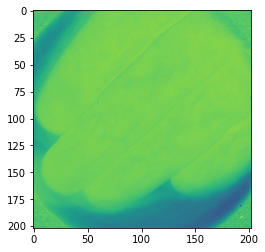

In [14]:
plt.imshow(melResult)

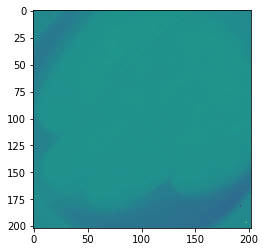

In [15]:
plt.imshow(BlsdbnResult)


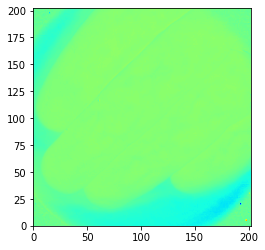

In [17]:
plt.imshow(BlsdbnResult,  extent=(0,x_total,0,y_total), cmap='jet')

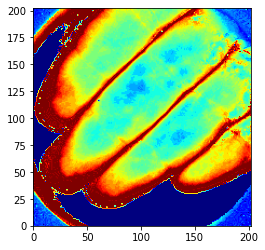

In [18]:
# load the provided npy file
plt.imshow(Results_from_given_npy[:,:,4],  extent=(0,x_total,0,y_total), cmap='jet')

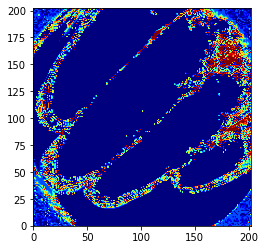

In [23]:
plt.imshow(Results_from_given_npy[:,:,10],extent=(0,x_total,0,y_total), cmap='jet')
